In [31]:
# standard DS/ML modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# data processing and feature engineering modules
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.impute import SimpleImputer

# out of the box models from sklearn 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# modules for model evaluation
from sklearn.metrics import (
    plot_roc_curve, 
    roc_curve, 
    accuracy_score, 
    classification_report,
    f1_score,
    multilabel_confusion_matrix,
    precision_recall_fscore_support,
    precision_score,
    recall_score,
    roc_auc_score,
    zero_one_loss,
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,r
    RocCurveDisplay,
    confusion_matrix
) 

In [2]:
mma_bout_data = pd.read_csv('./mma_data/ufc_historical_data.csv')

In [3]:
# removing the following columns as they don't seem to have predictive 
# value. things like the fighter's name, the date of the match, the referee
# also dropping weight class because it is categorical and thee are many categories
mma_bout_data = mma_bout_data.drop(['R_fighter', 'B_fighter', 'Referee', 'date', 'location', 'title_bout', 
                                    'weight_class','B_draw','R_draw'], axis=1)

# replacing missing values of reach with height where possible 
mma_bout_data['R_Reach_cms'].fillna(mma_bout_data['R_Height_cms'], inplace=True)
mma_bout_data['B_Reach_cms'].fillna(mma_bout_data['B_Height_cms'], inplace=True)

# replcae missing stances with 'Orthodox' which is the modal category
mma_bout_data['R_Stance'].fillna('Orthodox', inplace=True)
mma_bout_data['B_Stance'].fillna('Orthodox', inplace=True)

# drop all fights which ended as a draw, this is a rare outcome 
# removing this outcome turns the problem into a binary classification problem
mma_bout_data = mma_bout_data[mma_bout_data.Winner != "Draw"]

In [4]:
# handle categorical columns, just two left now - the stance of each fighter
categorical_cols = ['B_Stance', 'R_Stance']
numeric_cols = list(set(mma_bout_data.columns) - set(categorical_cols) - {'Winner'})

mma_bout_data = pd.get_dummies(mma_bout_data, columns=categorical_cols)

In [5]:
data_train, data_test = train_test_split(mma_bout_data, test_size=0.2,
                                        random_state = 888, stratify=mma_bout_data['Winner'])

In [51]:
data_train.shape

(4721, 143)

In [52]:
data_test.shape

(1181, 143)

In [6]:
# now set aside one-hot-encoded column titles for further processing on numeric columns
categorical_cols = ['B_Stance_Open Stance','B_Stance_Orthodox','B_Stance_Southpaw',
                    'B_Stance_Switch','R_Stance_Open Stance', 'R_Stance_Orthodox', 
                    'R_Stance_Southpaw', 'R_Stance_Switch']
numeric_cols = list(set(mma_bout_data.columns) - set(categorical_cols) - {'Winner'})

X_train_num = data_train[numeric_cols].copy()
X_train_cat = data_train[categorical_cols].copy()

# impute missing values where possible into the numeric columns 
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_num = imputer.fit_transform(X_train_num)

In [7]:
# scale the numerical data (normalize)
scaler = RobustScaler()
scaler.fit(X_train_num)

X_train_num = scaler.transform(X_train_num)
X_train_cat = X_train_cat.to_numpy()
X_train = np.hstack((X_train_num, X_train_cat))
y_train = data_train['Winner']

In [8]:
# do processing on test data to match training data - impute missing value
# and scaling 

# TODO: impute missing values in test data based on training data
# rationale - for new incoming data must rely on the training data that you have

X_test_num = data_test[numeric_cols].copy()
X_test_cat = data_test[categorical_cols].copy()

X_test_num = imputer.transform(X_test_num)

X_test_num = scaler.transform(X_test_num)

X_test_cat = X_test_cat.to_numpy()
X_test = np.hstack((X_test_num, X_test_cat))
y_test = data_test['Winner']

In [9]:
# Train logistic regression models, with and without regularization not many hyper parameters to tune otherwise
log_reg_clf = LogisticRegression(penalty='none', max_iter=3000)
log_reg_clf.fit(X_train, y_train)

log_reg_clf_l2 = LogisticRegression(penalty='l2', max_iter=3000)
log_reg_clf_l2.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [12]:
# train a multilayer perceptron neural net
mlp_clf = MLPClassifier(random_state=888)

mlp_param_grid = {
    'hidden_layer_sizes':[(1,),(2,),(5,),(10,),(50,),(100,)],
    'max_iter':[2000],
    'activation':['relu','tanh'],
    'solver':['sgd'],
    'alpha':[0.0001],
    'learning_rate':['constant']
}

mlp_tuned = GridSearchCV(mlp_clf, mlp_param_grid, cv=5)
mlp_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=MLPClassifier(random_state=888),
             param_grid={'activation': ['relu', 'tanh'], 'alpha': [0.0001],
                         'hidden_layer_sizes': [(1,), (2,), (5,), (10,), (50,),
                                                (100,)],
                         'learning_rate': ['constant'], 'max_iter': [2000],
                         'solver': ['sgd']})

In [13]:
lrc_cvscores = cross_val_score(log_reg_clf, X_train,y_train,cv=5)
lrc_cvscores.mean()

0.6918065644336832

In [14]:
lrcl2_cvscores = cross_val_score(log_reg_clf_l2, X_train,y_train,cv=5)
lrcl2_cvscores.mean()

0.6886290467222671

In [15]:
rf_cvscores = cross_val_score(rf_tuned.best_estimator_, X_train, y_train, cv=5)
rf_cvscores.mean()

0.6848134696439782

In [16]:
mlp_cvscores = cross_val_score(mlp_tuned.best_estimator_, X_train, y_train, cv=5)
mlp_cvscores.mean()

0.6903214958299704

In [17]:
log_reg_clf.score(X_train, y_train)

0.71383181529337

In [18]:
log_reg_clf.score(X_test, y_test)

0.6850127011007621

In [20]:
log_reg_clf_l2.score(X_train, y_train)

0.7102308832874391

In [21]:
log_reg_clf_l2.score(X_test, y_test)

0.6883996613039797

In [23]:
rf_tuned.best_estimator_.score(X_train, y_train)

1.0

In [24]:
rf_tuned.best_estimator_.score(X_test, y_test)

0.6816257408975445

In [25]:
mlp_tuned.best_estimator_.score(X_train, y_train)

0.7178563863588223

In [26]:
mlp_tuned.best_estimator_.score(X_test, y_test)

0.6850127011007621

In [28]:
rf_tuned.best_params_

{'max_depth': 100, 'max_features': 'auto', 'n_estimators': 1000}

In [53]:
mlp_tuned.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (2,),
 'learning_rate': 'constant',
 'max_iter': 2000,
 'solver': 'sgd'}

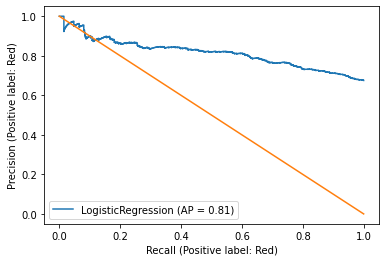

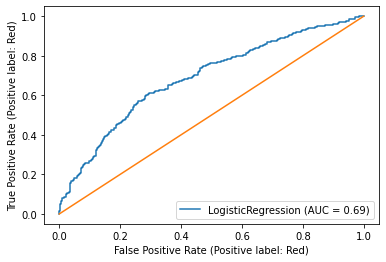

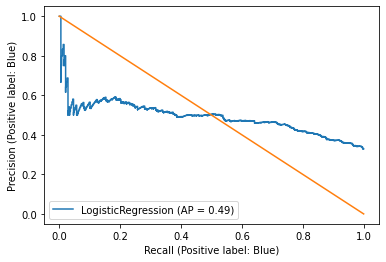

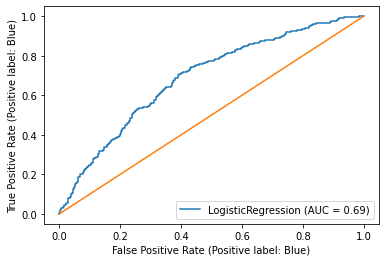

In [47]:
PrecisionRecallDisplay.from_estimator(log_reg_clf, X_test, y_test).ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test).ax_.plot([0,1],[0,1])
PrecisionRecallDisplay.from_estimator(log_reg_clf, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(log_reg_clf, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[0,1])

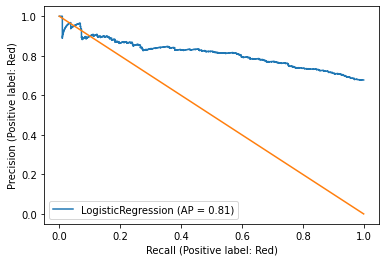

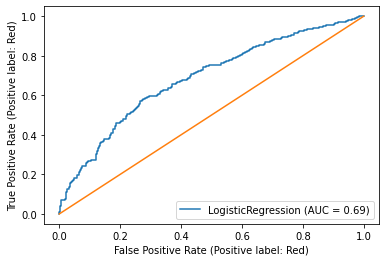

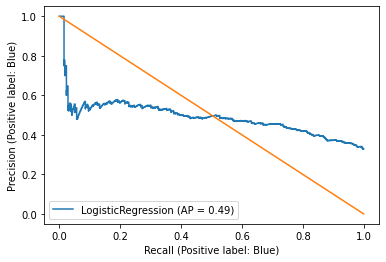

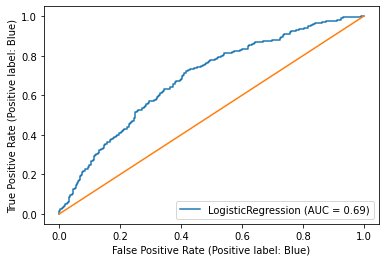

In [48]:
PrecisionRecallDisplay.from_estimator(log_reg_clf_l2, X_test, y_test).ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(log_reg_clf_l2, X_test, y_test).ax_.plot([0,1],[0,1])
PrecisionRecallDisplay.from_estimator(log_reg_clf_l2, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(log_reg_clf_l2, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[0,1])

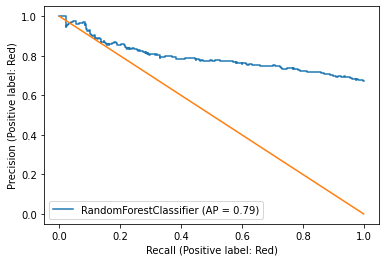

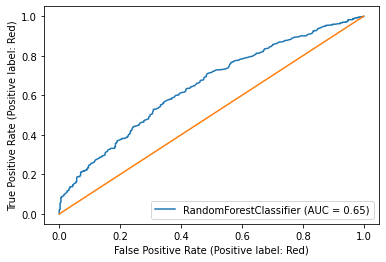

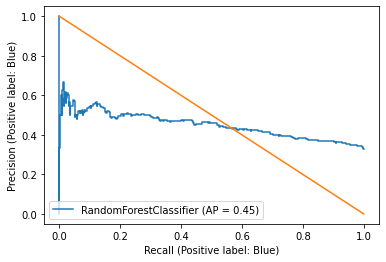

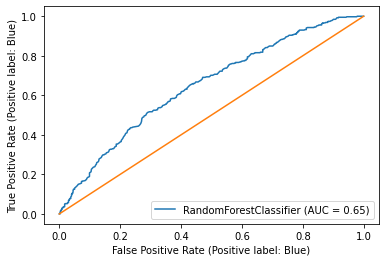

In [49]:
PrecisionRecallDisplay.from_estimator(rf_tuned.best_estimator_, X_test, y_test).ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(rf_tuned.best_estimator_, X_test, y_test).ax_.plot([0,1],[0,1])
PrecisionRecallDisplay.from_estimator(rf_tuned.best_estimator_, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(rf_tuned.best_estimator_, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[0,1])

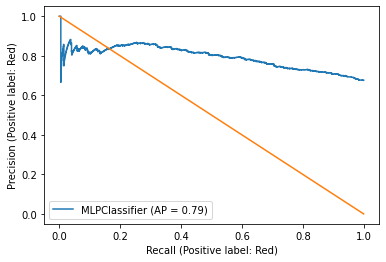

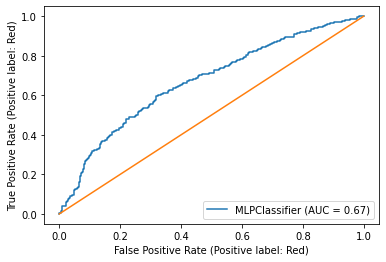

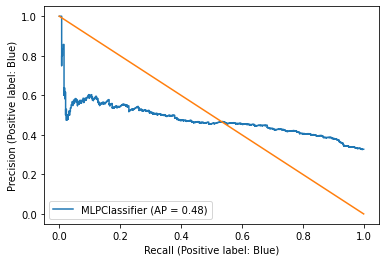

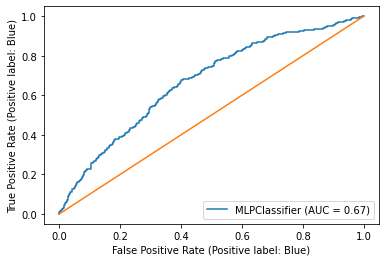

In [50]:
PrecisionRecallDisplay.from_estimator(mlp_tuned.best_estimator_, X_test, y_test).ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(mlp_tuned.best_estimator_, X_test, y_test).ax_.plot([0,1],[0,1])
PrecisionRecallDisplay.from_estimator(mlp_tuned.best_estimator_, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[1,0])
RocCurveDisplay.from_estimator(mlp_tuned.best_estimator_, X_test, y_test, pos_label="Blue").ax_.plot([0,1],[0,1])